## Activation Patching

In [1]:
import torch, transformer_lens, itertools
from functools import partial

from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np

def plot_heatmap(array, title='', cmap="binary"):
    titlefont, labelsize=12, 10
    fig, ax = plt.subplots(1, 1, figsize=(2, 4), gridspec_kw={'hspace': 0.4})
    ax = sns.heatmap(array, cmap=mpl.colormaps[cmap], xticklabels=hook_names, square=False)
    ax.set_title(title, fontsize=titlefont, color="black", loc='center')
    ax.set_ylabel('layers', fontsize=labelsize)
    plt.show()

In [2]:
model = transformer_lens.HookedTransformer.from_pretrained("gpt2-small").to("cpu")
model.cfg.spacing = "Ġ"
model.tokenizer.pad_token = model.tokenizer.eos_token

Using pad_token, but it is not set yet.


Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cpu


In [3]:
def patch_hook_point(patched_activs, hook: HookPoint, old_activs, hook_layer_name, extract_tok_idx=-1, insert_tok_idx=None):
    #print(f'patching {hook.name} <-- {hook_layer_name}')
    if extract_tok_idx is None or extract_tok_idx == -1:
        extract_tok_idx = (0, -1)
    if insert_tok_idx is None:
        insert_tok_idx = extract_tok_idx
    old_activs_hook = old_activs[hook_layer_name]
    patched_activs[insert_tok_idx] = old_activs_hook[extract_tok_idx]
    return patched_activs

In [4]:
def select_logits(logits, token_list=["friendly", "hostile"]): #["positive", "negative"], ["friendly", "hostile"]
    indices = torch.LongTensor([model.tokenizer.encode(f" {token}")[0] for token in token_list])
    logits = torch.index_select(logits, -1, indices)
    logits_v = logits / logits.sum()
    return logits_v[0].item() ## toDo: remove this later!


def get_vector_dist(vec_a, vec_b, norm=True):
    pdist = torch.nn.PairwiseDistance(p=2)
    if norm:
        vec_a = torch.nn.functional.normalize(vec_a, p=2.0, dim=-1)
        vec_b = torch.nn.functional.normalize(vec_b, p=2.0, dim=-1)
    vec_dist = pdist(vec_a, vec_b)
    return vec_dist

## (1) Check change

In [8]:
prompt = ["The relationship between Harry Potter and Ronald Weasley is"]
corrupt_prompt = ["The relationship between Mikel Black and Wesley Smith is"]

#prompt = ["The relationship between Harry Potter and Ronald Weasley is"]
#corrupt_prompt = ["Harry absolutely hates Ron. The relationship between Harry Potter and Ronald Weasley is"]

#prompt = ["The relationship between Biden and Trump is"]
#corrupt_prompt = ["Biden loves Trump. The relationship between Biden and Trump is"]


logits, activs = model.run_with_cache(prompt)
corrupt_logits, corrupt_activs = model.run_with_cache(corrupt_prompt)

logits_v = select_logits(logits[0,-1])
corrupt_logits_v = select_logits(corrupt_logits[0,-1])

print(logits_v, corrupt_logits_v)

0.5239638686180115 0.5196462869644165


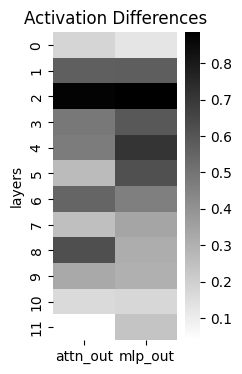

In [9]:
n_layers = model.cfg.n_layers
hook_names = ["attn_out", "mlp_out"]
diff_activs = torch.zeros(n_layers, len(hook_names)) ## times hook_names

for layer in range(n_layers):
    for hook_i, hook_name in enumerate(hook_names): 
        hook_layer_name = transformer_lens.utils.get_act_name(hook_name, layer)
        activ_hook, corrupt_activs_hook= activs[hook_layer_name], corrupt_activs[hook_layer_name]
        
        vec_dist = get_vector_dist(activ_hook[0,-1], corrupt_activs_hook[0,-1])
        diff_activs[layer, hook_i] = vec_dist
        
plot_heatmap(diff_activs.numpy(), title='Activation Differences', cmap="binary")

## (2) Find Mechanistic Module

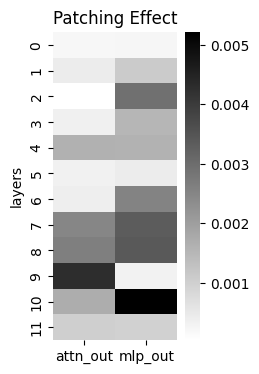

In [10]:
n_layers = model.cfg.n_layers
hook_names = ["attn_out", "mlp_out"]

patching_effect = torch.zeros(n_layers, len(hook_names)) ## times hook_names

for layer in range(n_layers):
    for hook_i, hook_name in enumerate(hook_names): 
        
        hook_layer_name = transformer_lens.utils.get_act_name(hook_name, layer)
        patch_layers_fn = [(hook_layer_name, partial(patch_hook_point, old_activs=corrupt_activs, hook_layer_name=hook_layer_name))]
        corrupt_logits = model.run_with_hooks(prompt,fwd_hooks=patch_layers_fn,reset_hooks_end=True)
        
        logits_v = select_logits(logits[0,-1])
        corrupt_logits_v = select_logits(corrupt_logits[0,-1])        
        patching_effect[layer, hook_i] = abs(logits_v-corrupt_logits_v)
        
plot_heatmap(patching_effect.numpy(), title='Patching Effect', cmap="binary")

In [12]:
#import circuitsvis as cv
#_, cache = model.run_with_cache(prompt[0])
#cv.attention.attention_patterns(tokens=model.to_str_tokens(prompt[0]),attention=cache['blocks.17.attn.hook_pattern'][0])